# Construction Cash Flow Optimization

### Importing Packages

In [124]:
import logging
import pickle
import numpy as np
import matplotlib.pyplot as plt

### Configuration

In [125]:
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s]%(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["figure.dpi"] = 120

### Initiate a project

In [126]:
class Project: pass  # Create a blank class
project = Project()  # Initiate a blank project object
project.start = np.datetime64("2019-01-01")
project.number_of_activities = 50
project.dur = np.zeros(project.number_of_activities)  # duration

### Randomize the project

In [127]:
# Randomize the durations, costs, and preds
project.dur = np.array([np.timedelta64(np.random.randint(5, 30), 'D') for i in range(project.number_of_activities)])
project.cost = np.random.randint(5, 20, size=(project.number_of_activities))
project.pred = [
    [i - np.random.randint(1, i), ] if i > 1 else [] 
    for i in range(project.number_of_activities)
]

### Financial Parameters for the project

In [128]:
project.downpayment = 0.15
project.retention = 0.1
project.payment_days = 28
project.markup = 0.05

## Calculate the project

In [129]:
# Initiate ES and EF
project.es = np.array([project.start for i in range(project.number_of_activities)])
project.ef = project.es + project.dur
# Perform Front Run
logging.info("Starting the Front Run...")
cond = True
while cond:
    cond = False
    for i in range(project.number_of_activities):
        for pred in project.pred[i]:
            if project.es[i] < project.ef[pred]:
                project.es[i] = project.ef[pred]
                project.ef[i] = project.es[i] + project.dur[i]
                cond = True
del cond
# Record the project finish
project.finish = project.ef.max()
# Perform the Back Run
logging.info("Starting the Back Run...")
# Intiate the LS and LF
project.lf = np.array([project.finish for i in range(project.number_of_activities)])
project.ls = project.lf - project.dur
cond = True
while cond:
    cond = False
    for i in range(project.number_of_activities):
        for pred in project.pred[i]:
            if project.lf[pred] > project.ls[i]:
                project.lf[pred] = project.ls[i]
                project.ls[pred] = project.lf[pred] - project.dur[pred]
                cond = True
del cond
# Calculate the TF
project.tf = project.ls - project.es
logging.info("Done!")

[23:20:24]INFO: Starting the Front Run...
[23:20:24]INFO: Starting the Back Run...
[23:20:24]INFO: Done!


## Plot the Calculated Schedule

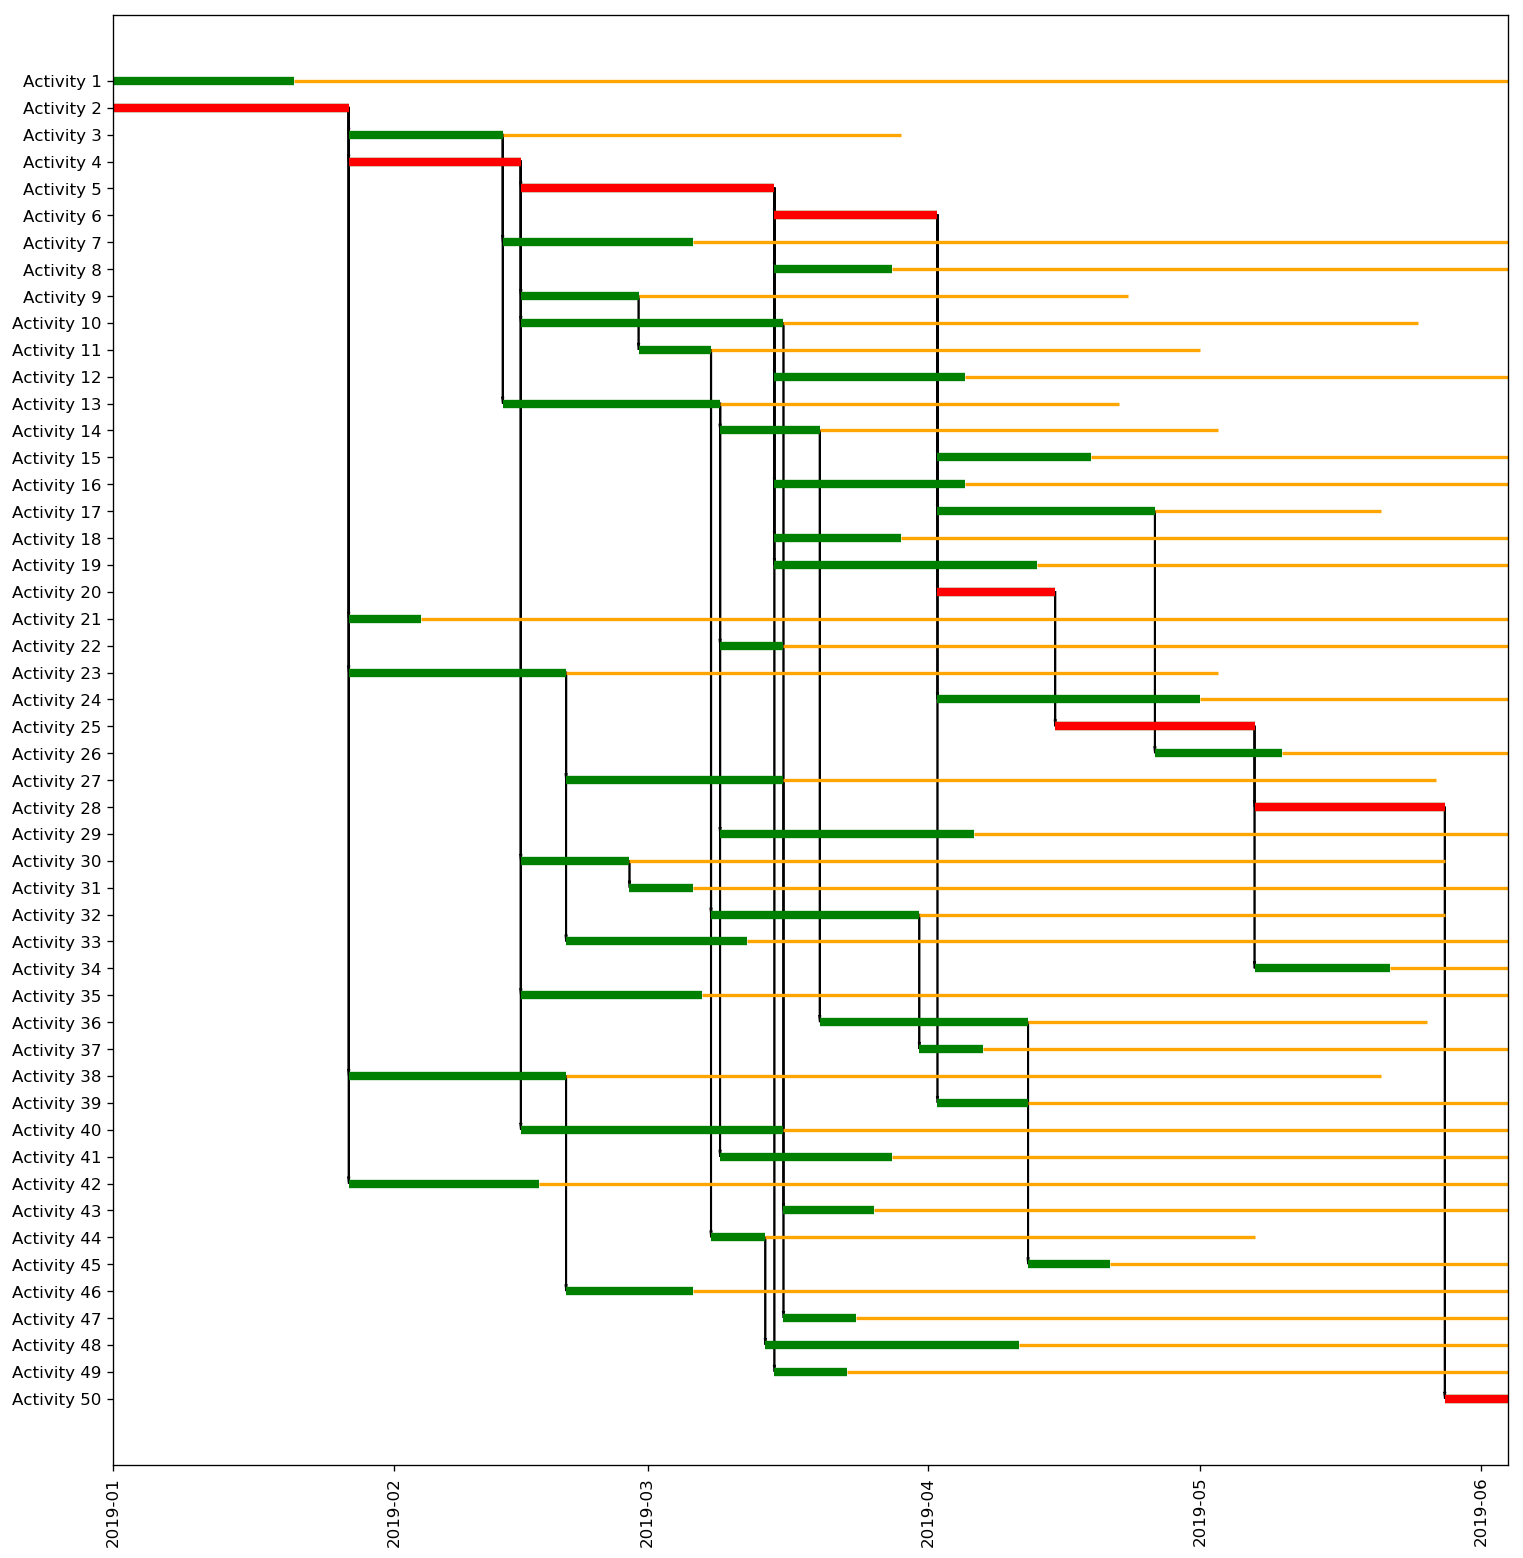

In [130]:
plt.figure(figsize=(15, int(project.number_of_activities / 3)))
# Draw Activities
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=project.es,
    xmax=project.ef,
    linewidth=5,
    color="green"
)
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=np.array([project.es[i] if project.es[i] == project.ls[i] else project.es[i] for i in range(project.number_of_activities)]),
    xmax=np.array([project.ef[i] if project.es[i] == project.ls[i] else project.es[i] for i in range(project.number_of_activities)]),
    linewidth=5,
    color="red"
)
# Draw Late
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=project.ef,
    xmax=project.lf,
    linewidth=2,
    color="orange"
)
# Draw Arrow
for i in range(project.number_of_activities):
    for pred in project.pred[i]:
        plt.arrow(
            x=project.ef[pred],
            y=pred,
            dx=(project.ef[pred]-project.es[i]).astype('timedelta64[D]')/np.timedelta64(1,"D"),
            dy=i-pred,
            length_includes_head=True,
            width=0.05,
            color="black"
        )
plt.xlim(project.start, project.finish)
plt.xticks(rotation=90)
plt.gca().invert_yaxis()
plt.show()

## Calculate the Cash-Flow

The total Project Price is 653.1
The total Cummulative CashIn is 653.0999999999999


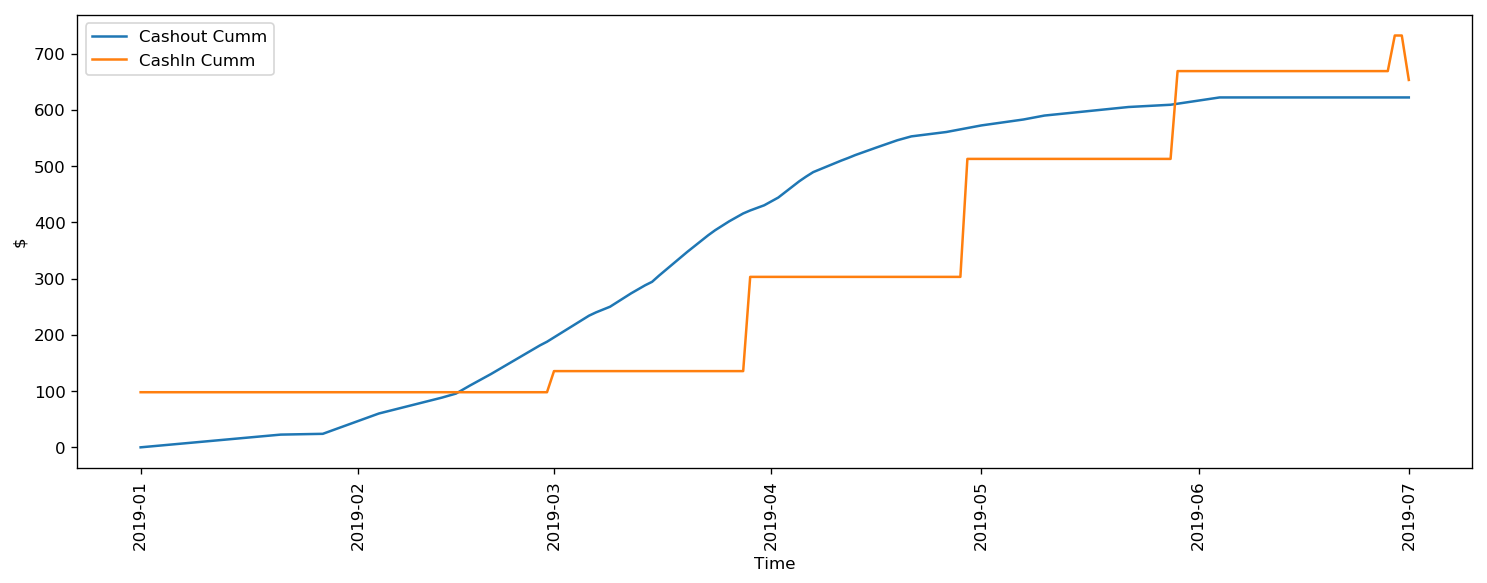

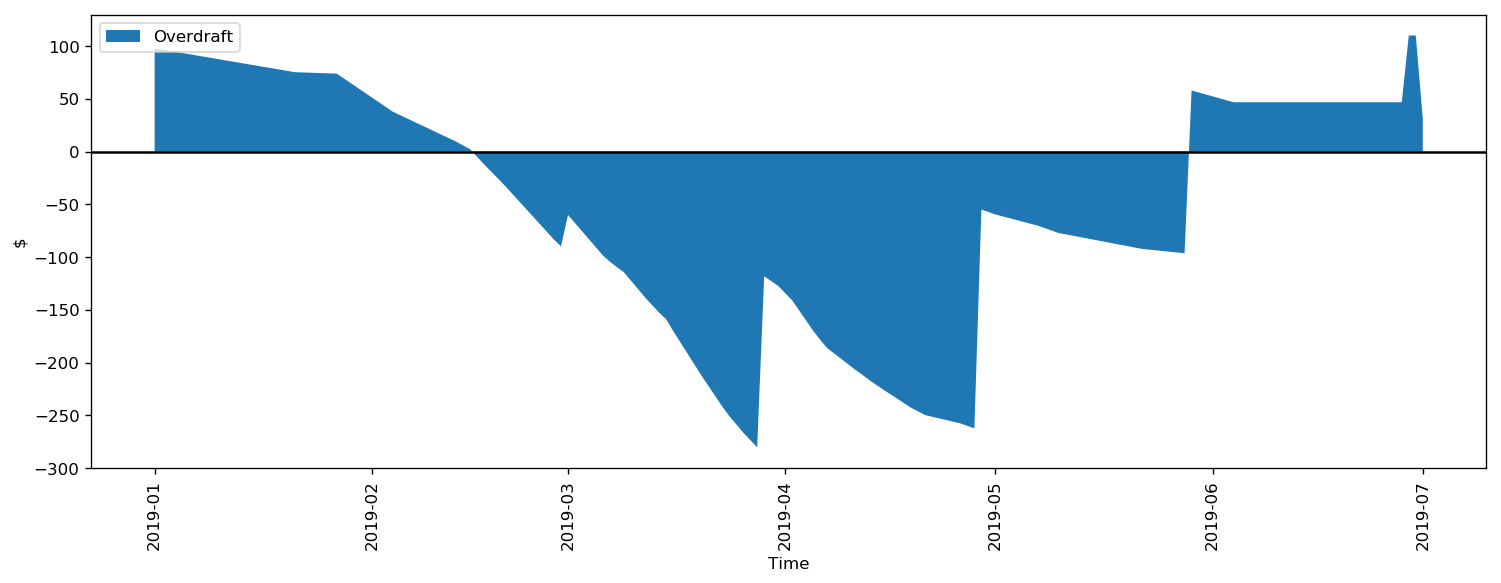

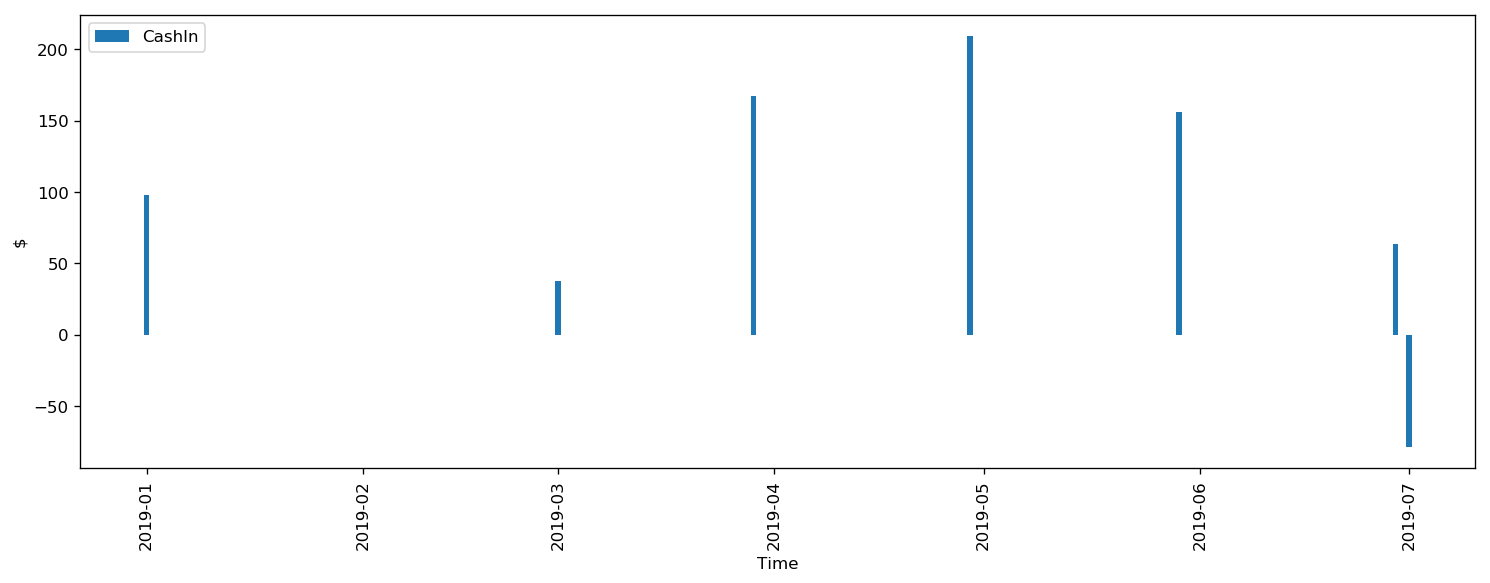

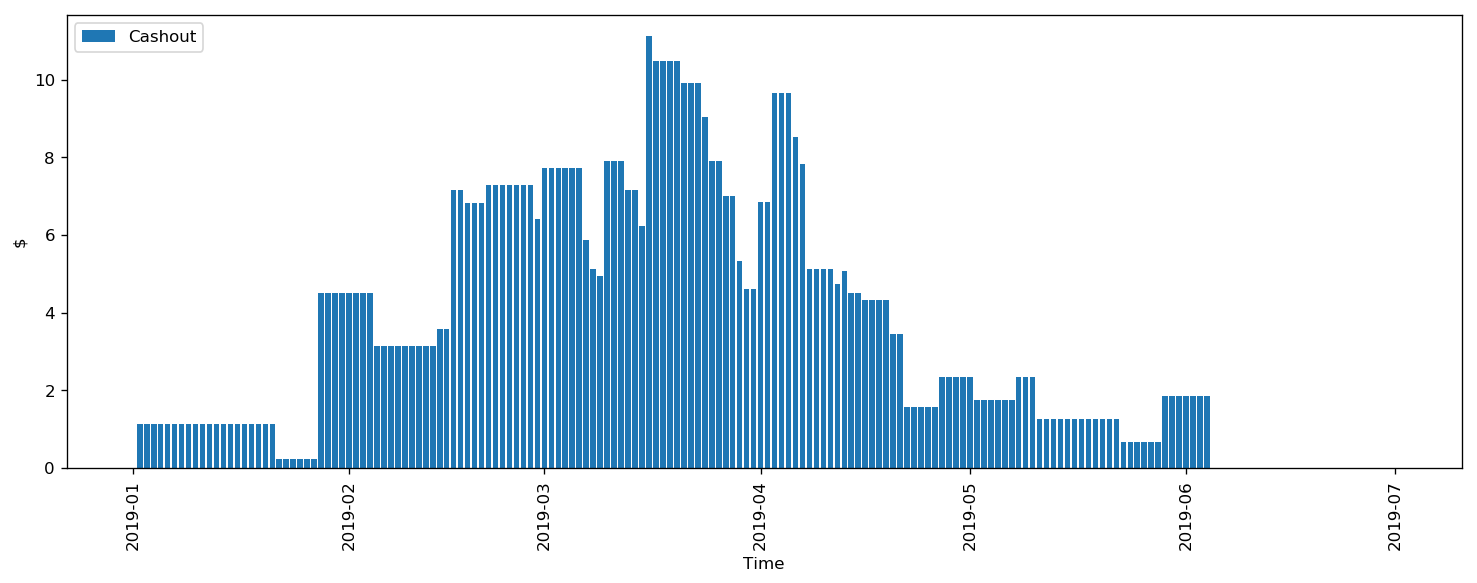

In [204]:
# Initiate an array with the dates
project.time = np.arange(project.start, project.finish + np.timedelta64(project.payment_days, "D"))
# Calculate the number of days
project.number_of_days = int((project.finish - project.start + np.timedelta64(project.payment_days, "D")) / np.timedelta64(1, "D"))
# Initiate the array for the cashflow
project.cashout = np.zeros(project.number_of_days)
# Calculate the cashout
for t in range(project.number_of_days):
    for i in range(project.number_of_activities):
        if project.time[t] > project.es[i] and project.time[t] <= project.ef[i]:
            project.cashout[t] += project.cost[i] / int(project.dur[i] / np.timedelta64(1, "D"))
# Calculate the cashin
project.cashin = np.zeros(project.number_of_days)
project.cashin[0] = project.cost.sum() * (1 + project.markup) * project.downpayment
for t in range(project.number_of_days):
    if t > project.payment_days and str(project.time[t - project.payment_days]).split("-")[2] == "01":
        project.cashin[t] += max(
            (
                project.cashout[0:t - project.payment_days].sum() * (1 + project.markup)
                - project.cashin[0:t - project.payment_days].sum()
                + project.cost.sum() * (1 + project.markup) * project.downpayment
            ) * (1 - project.downpayment) ,
            -999999999       
        )
project.cashin[project.number_of_days-1] = project.cost.sum() * (1 + project.markup) - project.cashin.sum()
print("The total Project Price is {}".format(project.cost.sum() * (1 + project.markup)))
print("The total Cummulative CashIn is {}".format(project.cashin.sum()))
# PLOT

plt.figure()
plt.plot(project.time, project.cashout.cumsum(), label="Cashout Cumm")
plt.plot(project.time, project.cashin.cumsum(), label="CashIn Cumm")
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=2)
plt.show()

plt.figure()
plt.fill_between(project.time, (project.cashin.cumsum() - project.cashout.cumsum()), label="Overdraft")
plt.axhline(0, color="Black")
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=2)
plt.show()

plt.figure()
plt.bar(project.time, project.cashin, label="CashIn")
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=2)
plt.show()

plt.figure()
plt.bar(project.time, project.cashout, label="Cashout")
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=2)
plt.show()